<!-- # <h1 style="text-align: center; font-size: 55px;">Power Analysis</h1> -->
<img src="pictures/Bsides_open_slide.png" width="95%" height="95%">

---
## Chipwhisperer Nano 

<img src="pictures/chipwhisperer.png" alt="ChipwhispererNano" width="95%" height="95%">

# Imports and Constants

In [1]:
from sklearn.decomposition import PCA
from collections import OrderedDict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import chipwhisperer as cw
import pandas as pd
import numpy as np
import time

SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_2_1'
NOPS_COMMAND = 'N'
SHL_COMMAND = 'U'
SLEEP_COMMAND = 'S'
ENCRYPT_COMMAND = 'E'
MATRIX_MULTIPLICATION_COMMAND = 'M'

# Some function defintions

In [2]:
# this cell is the only difference from the live demo notebook 
# definning the scope object to avoid changing other cells (e.g scope.adc.samples)
# and changing the 'get_trace' function is a genereator that uses precaptured traces

class EmptyClass:
    pass

scope = EmptyClass()
scope.adc = EmptyClass()
scope.io = EmptyClass()
scope.io.clkout = 7500000

precaptured_csv =  pd.read_csv('precaptured_traces.csv', index_col=0)
# this uses precaptured traces, this is function is the only difference from the live demo notebook
def get_trace(command, msg=[], response_buffer_len=0):
    if not hasattr(get_trace, 'precaptured_traces'):
        get_trace.precaptured_traces = precaptured_csv
        get_trace.index = 0

    if get_trace.index >= len(get_trace.precaptured_traces):
        return None

    trace = get_trace.precaptured_traces.iloc[get_trace.index].dropna().values
    get_trace.index += 1
    return trace

def normalize(signal):
    if signal.std() == 0:
        return signal
    return (signal - signal.mean()) / signal.std()

# assuming traces are normalized
def cosine_similarity(trace1, trace2):
    return np.dot(trace1, trace2)/(np.linalg.norm(trace1)*np.linalg.norm(trace2))

# Visualizing power traces
---

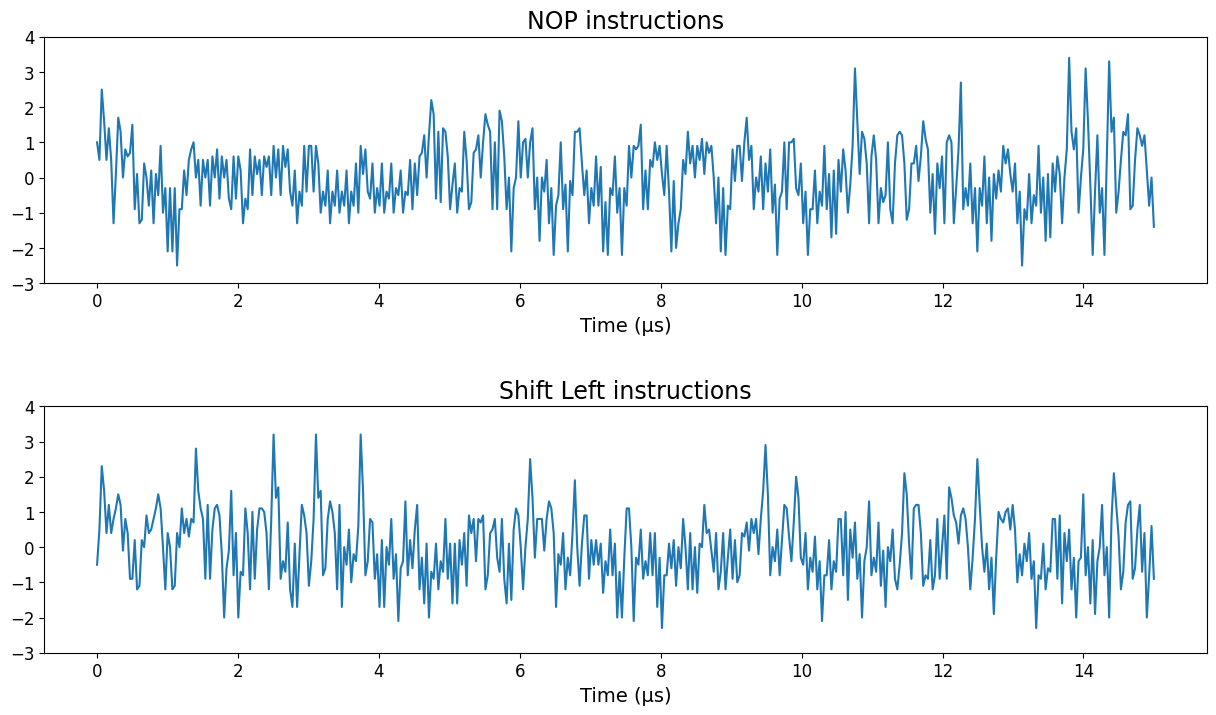

In [3]:
# for the algorithms in this part of the demo the running time is around 15 microseconds
running_time = 1.5 * (10 ** -5)

# set the sampling rate and number of samples per trace
scope.adc.clk_freq = 30*(10**6) 
scope.adc.samples = (running_time * scope.adc.clk_freq)

# capture two traces
nop_wave = get_trace(command=NOPS_COMMAND) # Execute NOP instructions
shl_wave = get_trace(command=SHL_COMMAND) # Execute SHL instructions

# Plot the traces
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
fig.subplots_adjust(hspace=0.5)

axs[0].plot(np.linspace(0, (running_time* 10**6), len(nop_wave)), nop_wave)
axs[0].set_title('NOP instructions', fontsize=17) ; axs[0].set_ylim([-3,4]) ; axs[0].tick_params(axis='both', labelsize=12); axs[0].set_xlabel("Time (\u03BCs)", fontsize=14)

axs[1].plot(np.linspace(0, (running_time* 10**6), len(shl_wave)), shl_wave)
axs[1].set_title('Shift Left instructions', fontsize=17); axs[1].set_ylim([-3,4]); axs[1].tick_params(axis='both', labelsize=12) ; axs[1].set_xlabel("Time (\u03BCs)", fontsize=14);

plt.show()

# Running Applications - AES, Matrix Multiplication, Idle
---

# Collect traces of 3 algorithms

In [4]:
# for the algorithms in this part of the demo the running time is around 6ms
running_time = 0.006

# set the sampling rate and number of samples per trace
scope.adc.clk_freq = 7500000
scope.adc.samples = (running_time * scope.adc.clk_freq)

# Set Encryption Key
key = bytearray.fromhex("2b7e151628aed2a6abf7158809cf4f3e")

plaintext = bytearray.fromhex("6bc1bee22e409f96e93d7e117393172b")
NUM_traces = 100
all_waves = []
application = []

for i in tqdm(range(NUM_traces), "Collecting AES Encryption traces"):
    wave = get_trace(command=ENCRYPT_COMMAND, msg=plaintext, response_buffer_len=16) # Encrypt command
    if wave is not None:
        all_waves.append(wave)
        application.append("AES Encryption")

for i in tqdm(range(NUM_traces), "Collecting Matrix Multiplication traces"):
    wave = get_trace(command=MATRIX_MULTIPLICATION_COMMAND) # Matrix multiplication command
    if wave is not None:
        all_waves.append(wave)
        application.append("Matrix Multiplication")

for i in tqdm(range(NUM_traces),  "Collecting Idle traces"):
    wave = get_trace(command=SLEEP_COMMAND) # Sleep command
    if wave is not None:
        all_waves.append(wave)
        application.append("Idle")


<font size="5">

## Capture Device code


```python
def get_trace(command, msg):
    # get ready for power trace capture
    scope.arm()

    # send the command
    target.simpleserial_write(command, msg)

    trace = scope.get_last_trace()
	
    return trace
```
</font>


<font size="5">

## Target Device code


```c
uint8_t encrypt(uint8_t* pt, uint8_t len)
{
	trigger_high();
	    aes_enc(pt); // encrypting the data block 
	trigger_low();
	simpleserial_put('r', 16, pt); // write back cipher
	return 0x00;
}
```
</font>

# Plot one of each type

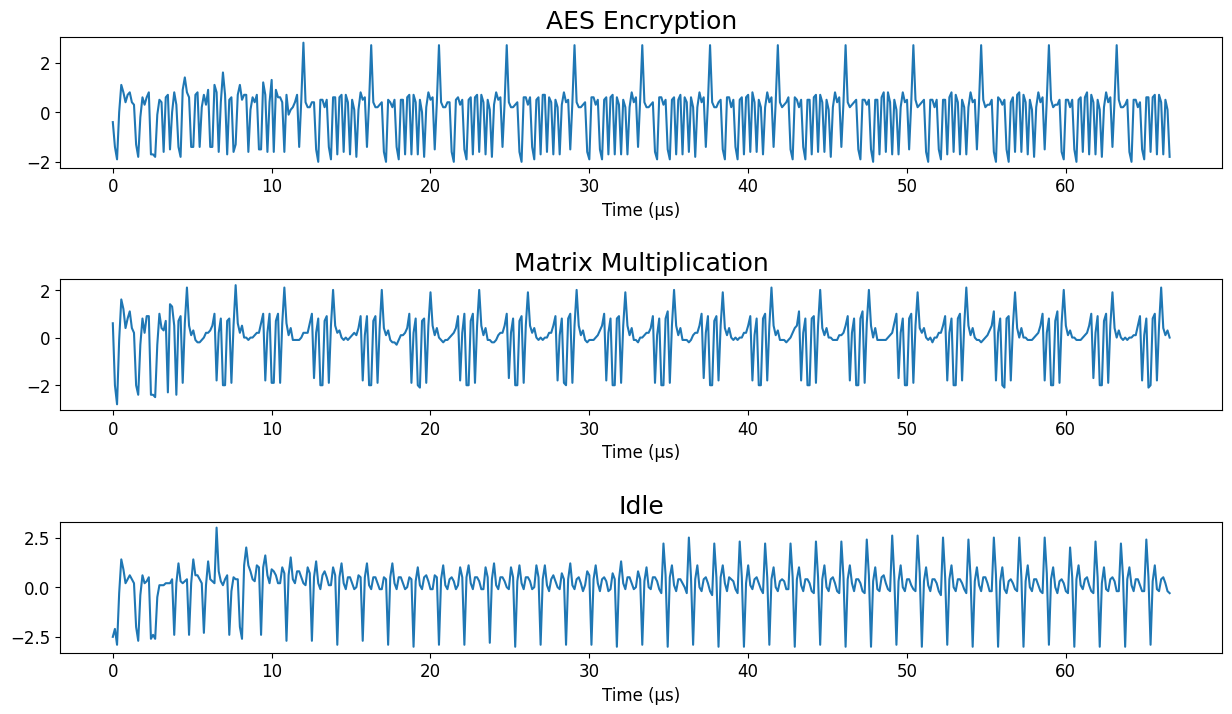

In [5]:
application1_offset = 0
application2_offset = NUM_traces + 1
application3_offset =(2*NUM_traces) + 1

plot_length = 500
start_offset = 0

application1_trace1 = all_waves[application1_offset]
application1_trace2 = all_waves[application1_offset+1]

application2_trace1 = all_waves[application2_offset]
application2_trace2 = all_waves[application2_offset+1]

application3_trace1 = all_waves[application3_offset]
application3_trace2 = all_waves[application3_offset+1]

x = np.linspace(0, (running_time* (10**6)), len(all_waves[0])) # all traces are the same length so this is ok
x = x[start_offset:start_offset + plot_length]

# Create a figure and three subplots
fig, axs = plt.subplots(3, 1, figsize=(15,8 ))
fig.subplots_adjust(hspace=0.85)

axs[0].plot(x, application1_trace1[start_offset: start_offset + plot_length])
axs[0].set_title(application[application1_offset], fontsize=18) ;axs[0].tick_params(axis='both', labelsize=12); axs[0].set_xlabel("Time (\u03BCs)", fontsize=12)

axs[1].plot(x, application2_trace1[start_offset: start_offset + plot_length])
axs[1].set_title(application[application2_offset], fontsize=18)  ;axs[1].tick_params(axis='both', labelsize=12); axs[1].set_xlabel("Time (\u03BCs)", fontsize=12)

axs[2].plot(x, application3_trace1[start_offset: start_offset + plot_length])
axs[2].set_title(application[application3_offset], fontsize=18) ; axs[2].tick_params(axis='both', labelsize=12); axs[2].set_xlabel("Time (\u03BCs)", fontsize=12)

plt.show()

# Calculate the Similarity between traces

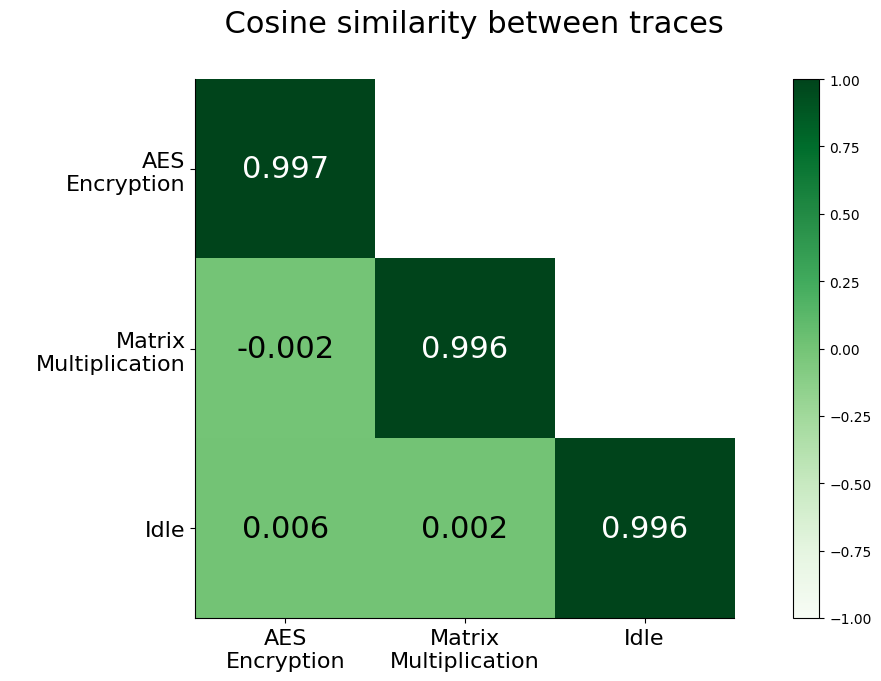

In [6]:
cosine_similarity_matrix = np.array([
    [cosine_similarity(application1_trace1, application1_trace2), np.NaN, np.NaN],
    [cosine_similarity(application2_trace1, application1_trace1), cosine_similarity(application2_trace1, application2_trace2), np.NaN],
    [cosine_similarity(application3_trace1, application1_trace1), cosine_similarity(application3_trace1, application2_trace1), cosine_similarity(application3_trace1, application3_trace2)],
])

application_names = [f"{application[application1_offset]}".replace(' ', '\n'), f"{application[application2_offset]}".replace(' ', '\n'), f"{application[application3_offset]}".replace(' ', '\n')]
fig, ax = plt.subplots(figsize=(15,7))
fig.suptitle("                      Cosine similarity between traces", fontsize=22, ha='center')


# Plot the heatmap using imshow with masked values
im = ax.imshow(cosine_similarity_matrix, cmap='Greens', vmin=-1, vmax=1)

# Set the ticks and labels
ax.set_xticks(np.arange(len(application_names)))
ax.set_yticks(np.arange(len(application_names)))
ax.set_xticklabels(application_names, fontsize=16)
ax.set_yticklabels(application_names, fontsize=16)

# Add value annotations to each cell
for i in range(len(application_names)):
    for j in range(len(application_names)):
        if i >= j:  # Only add annotations for the lower triangle and diagonal
            text_color = 'white' if cosine_similarity_matrix[i, j] > 0.5 else 'black'
            text = ax.text(j, i, "{:.3f}".format(cosine_similarity_matrix[i, j]), ha="center", va="center", color=text_color, fontsize=22)

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the title
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()


# Apply dimensionality Reduction - PCA

In [7]:
waves_as_np = np.array(all_waves) # waves as np array

unique_labels = list(OrderedDict.fromkeys(application)) # keep the order of applications

color_mapping = {element: index for index, element in enumerate(unique_labels)} # application_name to color
reverse_color_mapping = {value: key for key, value in color_mapping.items()} # color to application name
colors = np.array([color_mapping[element] for element in application])

# Dimensionality reduction
pca = PCA(n_components=3, random_state=123)
pca_data =pca.fit_transform(waves_as_np)

# Visualize in 3d

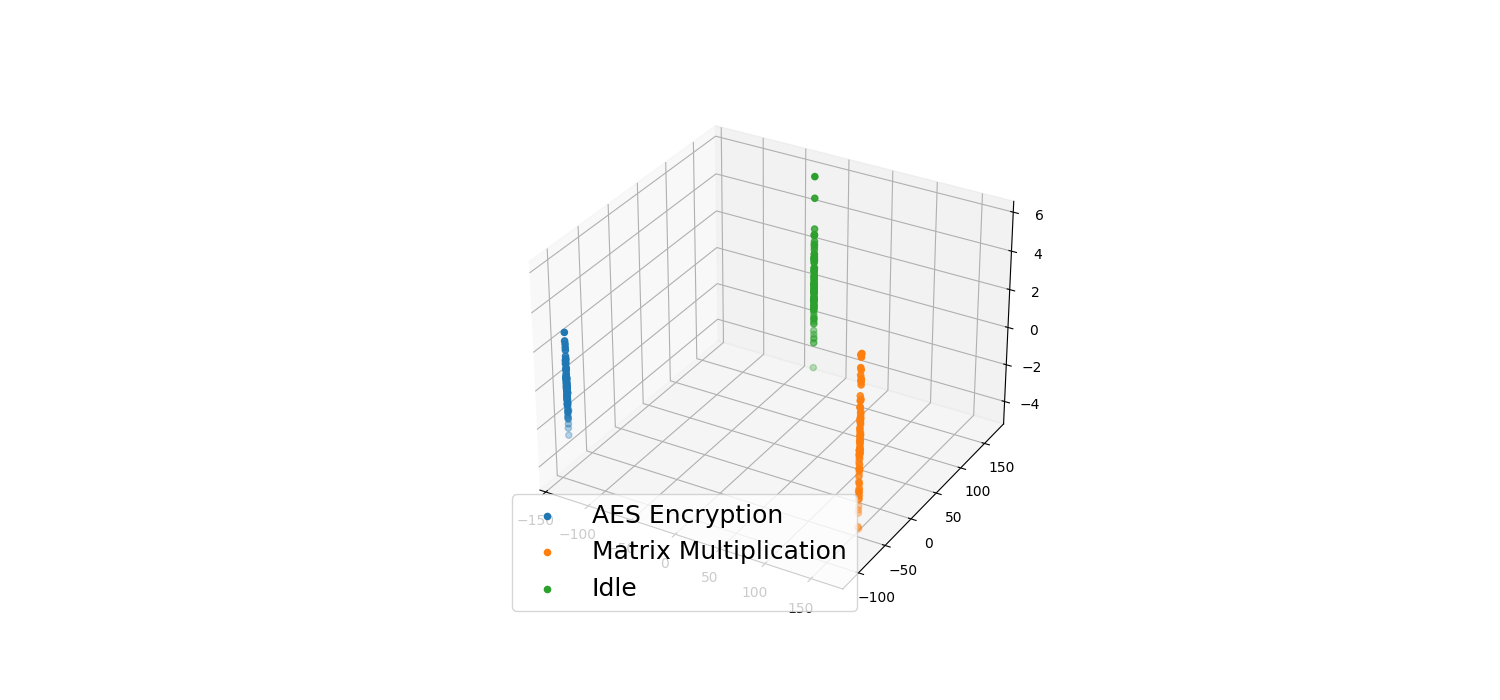

In [8]:
%matplotlib widget
# visualize in 3d
fig = plt.figure('Scatter Of Traces', figsize=(15,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# plot each application seperately
for color in color_mapping.values():
    mask = colors == color
    ax.scatter(pca_data[:, 0][mask],pca_data[:, 1][mask],pca_data[:, 2][mask], label=reverse_color_mapping[color])

ax.legend(fontsize=18)
plt.show()

# Data Also Matters

In [9]:
plaintext1 = bytearray.fromhex("6bc1bee22e409f96e93d7e117393172b")
plaintext2 = bytearray.fromhex("6bc1bee22e409f96e93d7e117393172c")
NUM_traces = 100
all_waves1 = []
application1 = []

for i in tqdm(range(NUM_traces), "Collecting AES Encryption traces - plaintext1"):
    wave = get_trace(command=ENCRYPT_COMMAND, msg=plaintext1, response_buffer_len=16) # Encrypt command
    if wave is not None:
        all_waves1.append(wave)
        application1.append("AES Encryption plaintext1")

for i in tqdm(range(NUM_traces), "Collecting AES Encryption traces - plaintext2"):
    wave = get_trace(command=ENCRYPT_COMMAND, msg=plaintext2, response_buffer_len=16) # Encrypt command
    if wave is not None:
        all_waves1.append(wave)
        application1.append("AES Encryption plaintext2")


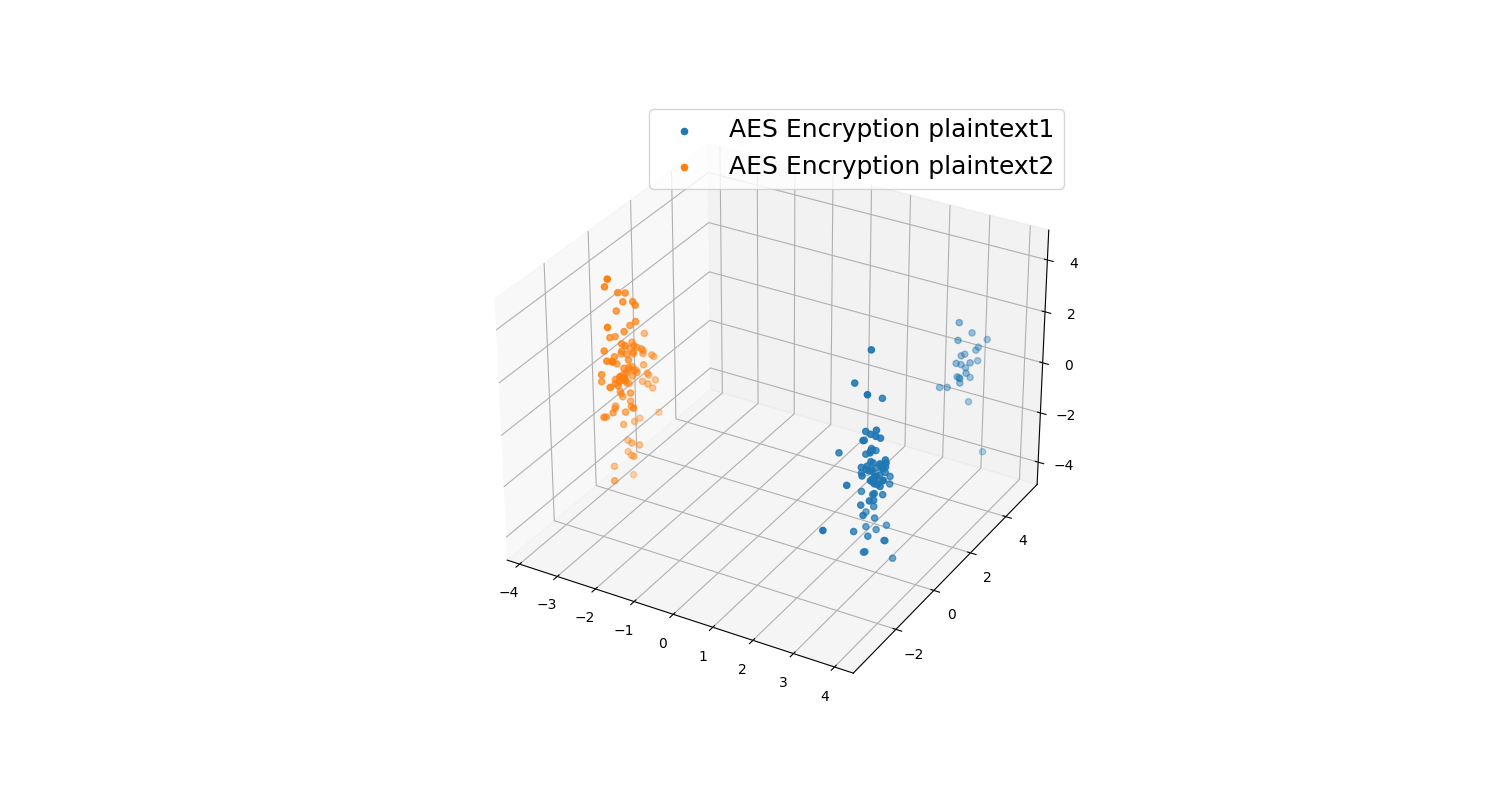

In [10]:
waves_as_np1 = np.array(all_waves1) # waves as np array

unique_labels1 = list(OrderedDict.fromkeys(application1)) # keep the order of applications

color_mapping1 = {element: index for index, element in enumerate(unique_labels1)} # application_name to color
reverse_color_mapping1 = {value: key for key, value in color_mapping1.items()} # color to application name
colors1 = np.array([color_mapping1[element] for element in application1])

# Dimensionality reduction
pca1 = PCA(n_components=3)
pca_data1 =pca.fit_transform(waves_as_np1)

# visualize in 3d
fig = plt.figure('AES Encryption with 2 plaintext', figsize=(15,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# plot each application seperately
for color in color_mapping1.values():
    mask = colors1 == color
    ax.scatter(pca_data1[:, 0][mask],pca_data1[:, 1][mask],pca_data1[:, 2][mask], label=reverse_color_mapping1[color])

ax.legend(fontsize=18)
plt.show()

<img src="pictures/Bsides_end_slide.png" width="90%" height="90%">
